In [211]:
import pandas as pd
import numpy as np

import os
import sys
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

In [268]:
warnings.filterwarnings('ignore')

In [269]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [270]:
sns.set_context('notebook')

In [271]:
df = pd.read_csv('../../../datasets_11657_16098_train.csv')

In [272]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.25000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.28330,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.92500,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.10000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.05000,NaN,S


In [273]:
df.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [274]:
data = df [df.columns[df.dtypes !='object']].dropna()

In [275]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [276]:
data.Survived.value_counts(normalize=True)

0   0.59384
1   0.40616
Name: Survived, dtype: float64

In [277]:
data.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
dtype: int64

In [278]:
Feat_col = data.columns[2:]
target_col = data.Survived

In [279]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.loc[:,Feat_col] = scaler.fit_transform(data.loc[:,Feat_col])

In [280]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,714.00000,714.00000,714.00000,714.00000,714.00000,714.00000,714.00000
mean,448.58263,0.40616,-0.00000,0.00000,-0.00000,-0.00000,-0.00000
std,259.11952,0.49146,1.00070,1.00070,1.00070,1.00070,1.00070
min,1.00000,0.00000,-1.47636,-2.01698,-0.55170,-0.50590,-0.65608
25%,222.25000,0.00000,-1.47636,-0.65954,-0.55170,-0.50590,-0.50385
50%,445.00000,0.00000,-0.28257,-0.11705,-0.55170,-0.50590,-0.35840
75%,677.75000,1.00000,0.91123,0.57183,0.52457,0.66686,-0.02495
max,891.00000,1.00000,0.91123,3.46513,4.82966,6.53065,9.03211


In [281]:
corr_values = data[Feat_col].corr()

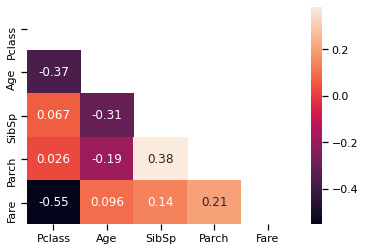

In [282]:
sns.heatmap(corr_values,annot=True,mask=np.triu(np.ones_like(corr_values, dtype=bool)))
plt.show()

In [283]:
from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV, StratifiedKFold

statr_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

train_idx, test_idx = next(statr_shuf_split.split(data[Feat_col],target_col))

X_train = data.reset_index().loc[train_idx,Feat_col]
y_train = data.reset_index().loc[train_idx, 'Survived']


X_test = data.reset_index().loc[test_idx,Feat_col]
y_test = data.reset_index().loc[test_idx,'Survived']

In [284]:
y_test.value_counts(normalize=True)

0   0.59441
1   0.40559
Name: Survived, dtype: float64

In [285]:
y_train.value_counts(normalize=True)

0   0.59370
1   0.40630
Name: Survived, dtype: float64

In [336]:
from sklearn.linear_model import LogisticRegression

In [337]:
lg = LogisticRegression().fit(X_train,y_train)

In [338]:
lg

LogisticRegression()

In [339]:
param_ = {'C': 10.0 **np.arange(-2,3),
         'penalty':['l1','l2']}

In [340]:
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [376]:
lg_grid = GridSearchCV(LogisticRegression(),param_grid=param_, cv=cv,scoring='roc_auc').fit(X_train,y_train)

In [377]:
lg_grid.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [378]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [379]:
os = RandomOverSampler()
X_train_os, y_train_os = os.fit_resample(X_train,y_train)
print('The number of classes before fit {}'.format(Counter(y_train)))
print('The number of classes before fit {}'.format(Counter(y_train_os)))

The number of classes before fit Counter({0: 339, 1: 232})
The number of classes before fit Counter({0: 339, 1: 339})


In [380]:
lg_os = GridSearchCV(LogisticRegression(),param_grid=param_, cv=cv,scoring='roc_auc').fit(X_train_os, y_train_os)

In [381]:
from sklearn.metrics import precision_recall_fscore_support as score

metrics = []
for model in [lg,lg_grid, lg_os]:
    precision, recall, fscore, _ = score(y_test, model.predict(X_test),average='weighted')
    
    metrics.append(pd.Series({'precision':precision,
                             'recall':recall,
                             'f1':fscore}))
metrics = pd.concat(metrics,axis=1)

In [382]:
metrics

,0,1,2
precision,0.70379,0.71933,0.67046
recall,0.70629,0.72028,0.67133
f1,0.69543,0.70993,0.67086
